# Convolutional Variational Autoencoder

## Setup

In [5]:
from IPython import display

import glob
import imageio
import numpy as np
import PIL
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import time
import os
import gc
import tarfile
import io
from functools import reduce


## Load the original dataset
This dataset was created for the cGAN that proficiently segmented the burrs form the rgb soles of the image. In this context the input images will be predicted with the trained cGAN as binary burrs. While the ground truth will be the external edges of these burrs obtained through image processing.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!tar -xvf "/content/drive/MyDrive/Colab_Notebooks/20k_dataset_v8.tar" # sim
!tar -xvf "/content/drive/MyDrive/Colab_Notebooks/500_dataset_real_v8.tar" # real

Output streaming troncato alle ultime 5000 righe.
train_img/image_train_7387.png
train_img/image_train_7388.png
train_img/image_train_7389.png
train_img/image_train_739.png
train_img/image_train_7390.png
train_img/image_train_7391.png
train_img/image_train_7392.png
train_img/image_train_7393.png
train_img/image_train_7394.png
train_img/image_train_7395.png
train_img/image_train_7396.png
train_img/image_train_7397.png
train_img/image_train_7398.png
train_img/image_train_7399.png
train_img/image_train_74.png
train_img/image_train_740.png
train_img/image_train_7400.png
train_img/image_train_7401.png
train_img/image_train_7402.png
train_img/image_train_7403.png
train_img/image_train_7404.png
train_img/image_train_7405.png
train_img/image_train_7406.png
train_img/image_train_7407.png
train_img/image_train_7408.png
train_img/image_train_7409.png
train_img/image_train_741.png
train_img/image_train_7410.png
train_img/image_train_7411.png
train_img/image_train_7412.png
train_img/image_train_741

In [2]:
!ls

drive		 real_test_img	   real_train_img  test_burrs  train_burrs  val_burrs
real_test_burrs  real_train_burrs  sample_data	   test_img    train_img    val_img


## Load the trained cGAN

In [6]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS)

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH, INPUT_CHANNELS])

  down_stack = [
    downsample(32, 4, apply_batchnorm=False),  # (batch_size, 256, 256, 32)
    downsample(64, 4),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512) -> use this as latent vector
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    upsample(32, 4),  # (batch_size, 256, 256, 64)
 ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 512, 512, 1)

  x = inputs


  skips = []
  for down in down_stack:
      x = down(x)
      skips.append(x)

  skips = reversed(skips[:-1])


  latent_activations = []  # Store intermediate activations for each layer
  for up, skip in zip(up_stack, skips):
      x = up(x)
      x = tf.keras.layers.Concatenate()([x, skip])
      latent_activations.append(skip)  # Store the activation of this layer

  x = last(x)
  latent = latent_activations[0] #dim (1,2,2,512) = 2048

  return tf.keras.Model(inputs=inputs, outputs=[x])

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH, INPUT_CHANNELS], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH, OUTPUT_CHANNELS], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, INPUT_CHANNELS+OUTPUT_CHANNELS)

  down0 = downsample(IMG_WIDTH//8, 4, False)(x)  # (batch_size, 128, 128, 64)
  down1 = downsample(IMG_WIDTH//4, 4)(down0)  # (batch_size, 128, 128, 64)
  down2 = downsample(IMG_WIDTH//2, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(IMG_WIDTH, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(IMG_WIDTH*2, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

generator = Generator()
discriminator = Discriminator()

In [7]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
checkpoint_dir = 'drive/MyDrive/Colab_Notebooks/v8/checkpoints_gan_20k'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint('drive/MyDrive/Colab_Notebooks/v8/checkpoints_gan_20k/512x512_gamma0.5_lambda500_120k_it_best_on_sim/'))

## Build a dataset for further processing.
The cGAN is able to perform image segmentation and separate the burr area (as binary image) from the rgb image of ther sole. The next goal is to encode this burr area into its external contour. To do so we're going to train an additional network. To generate the datasets to train on this network we're going to apply some further image processing

In [8]:
def enlarge_contour(decoded_img, size_cont):
  _, decoded_bin = cv2.threshold(decoded_img, 250, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  decoded_bin = cv2.bitwise_not(decoded_bin)
  contours, hierarchy = cv2.findContours(decoded_bin, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
  size_cont = 10
  decoded_contoured_big = cv2.drawContours(decoded_img.copy(), contours, -1, (255, 255, 255), size_cont)
  return decoded_contoured_big

def find_bigger_burr_cont(decoded_img): # Finder thicker burrs conotur
  # Find the entire contour of the decoded burr
  size_cont = 10
  decoded_contoured_big = enlarge_contour(decoded_img.copy(),size_cont)
  # Find contours in the bigger(with thick contours) decoded image
  contours_big, _ = cv2.findContours(decoded_contoured_big, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
  # Find the contour with the largest area
  if contours_big:
    largest_contour = max(contours_big, key=cv2.contourArea)
  else:
    largest_contour=contours_big


  return size_cont, largest_contour

def Extract_burr(decoded_img): # Extract the burr without small imperfections from decoder
  # Find thick contours of the burrs
  size_cont, largest_contour = find_bigger_burr_cont(decoded_img)

  # Create a binary image with only the largest contour
  burr = np.zeros_like(decoded_img)
  if len(largest_contour)>0:
    burr_big = cv2.drawContours(burr.copy(), [largest_contour],-1, (255, 255, 255), -1)

    kernel = np.ones((size_cont, size_cont), np.uint8)
    # Erode image to readjust the tjickness of the added contours
    burr = cv2.erode(burr_big, kernel, iterations=1)

  return burr

def skeletonize(img):
  """ OpenCV function to return a skeletonized version of img, a Mat object"""

  #  hat tip to http://felix.abecassis.me/2011/09/opencv-morphological-skeleton/

  img = img.copy() # don't clobber original
  skel = img.copy()

  skel[:,:] = 0
  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

  while True:
      eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
      temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
      temp  = cv2.subtract(img, temp)
      skel = cv2.bitwise_or(skel, temp)
      img[:,:] = eroded[:,:]
      if cv2.countNonZero(img) == 0:
          break

  return skel

# Find if there are more than one burr (excluding the imperfections)
def more_than_one_burr(decoded_img):
  # Find thick contours of the burrs
  _, largest_contour = find_bigger_burr_cont(decoded_img)
  thresh_area_cont = 500
  if len(largest_contour)>0 and cv2.contourArea(largest_contour)>thresh_area_cont:
    result = True
  else:
    result = False
  return result

def Extract_burrs(decoded_img):
  more_burr=True
  # Create a binary image with only the largest contour
  result = np.zeros_like(decoded_img)
  dec_img = decoded_img.copy()
  while more_burr:
    burr = Extract_burr(dec_img)
    result = cv2.add(result, burr)
    result_big = enlarge_contour(result.copy(),size_cont=3) # to not get residual contour in subtraction later
    rest_of_dec = cv2.subtract(decoded_img.copy(), result_big)
    more_burr = more_than_one_burr(rest_of_dec)
    dec_img = rest_of_dec
  return result

Define the overall transformation pipeline to extract the external contour of the burr

In [9]:
def Extract_contour(input_img, decoded_img): # Extract the external contour (single pixel curve) of the burr
  decoded_img = Extract_burrs(decoded_img) # processed decoded image(get rid of imperfections)
  # Find the shape of the input_img
  _, input_shape = cv2.threshold(cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY), 250, 255, cv2.THRESH_BINARY_INV+ cv2.THRESH_OTSU)

  # Find the entire contour of the decoded burr
  _, decoded_bin = cv2.threshold(decoded_img, 250, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  decoded_bin = cv2.bitwise_not(decoded_bin)
  contours_burr, hierarchy = cv2.findContours(decoded_bin, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
  decoded_contoured = cv2.drawContours(decoded_img.copy(), contours_burr, -1, (255, 255, 255), 5)

  # Extract just the external contour of the burr
  decoded_ext_cont = cv2.subtract(decoded_contoured.copy(), input_shape.copy())

  # Thinning the contour to achieve a constant thickness of 1 pixel
  #print('\nExtracting burr contour...')
  decoded_ext_cont  = skeletonize(decoded_ext_cont)

  return decoded_img, decoded_ext_cont

Define functions to process and load the data into the datasets

In [10]:
IMG_HEIGHT_VAE = 240
IMG_WIDTH_VAE = 320

def load(image_file , type):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  if type=='gray':
    image = tf.io.decode_png(image, channels=1)
  else:
    image = tf.io.decode_png(image, channels=3)
  image = tf.image.resize(image,(IMG_HEIGHT,IMG_WIDTH))
  # Convert both images to float32 tensors
  image = tf.cast(image, tf.float32)

  return image

def process_image(gan_input_img, gan_target_img):
  dec_img = generator(gan_input_img, training=True) # image decoded with trained cgan generator
  dec_img = tf.image.resize(dec_img[0], [IMG_HEIGHT_VAE, IMG_WIDTH_VAE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  dec_img = np.array(tf.keras.utils.array_to_img(dec_img), dtype=np.uint8)
  gan_input_img = tf.image.resize(gan_input_img[0], [IMG_HEIGHT_VAE, IMG_WIDTH_VAE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  gan_input_img = np.array(tf.keras.utils.array_to_img(gan_input_img), dtype=np.uint8)
  burr_img, cont_img = Extract_contour(gan_input_img, dec_img) # extrated burr, extracted external contour from decoded img
  burr_img = burr_img.reshape(IMG_HEIGHT_VAE, IMG_WIDTH_VAE,1)

  cont_img = cont_img.reshape(IMG_HEIGHT_VAE, IMG_WIDTH_VAE,1)

  burr_tensor = tf.convert_to_tensor(burr_img)
  contour_tensor = tf.convert_to_tensor(cont_img)
  return burr_tensor, contour_tensor


def process_images(gan_input_img, gan_target_img):
    burr_img, contour_img = tf.py_function(process_image, [gan_input_img, gan_target_img], [tf.uint8, tf.uint8])
    burr_img = tf.cast(burr_img, tf.float32)/255.0
    contour_img = tf.cast(contour_img, tf.float32)/255.0
    burr_img = tf.reshape(burr_img, (1, IMG_HEIGHT_VAE, IMG_WIDTH_VAE, 1))
    contour_img = tf.reshape(contour_img, (1, IMG_HEIGHT_VAE, IMG_WIDTH_VAE, 1))
    return burr_img, contour_img

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def normalize(input_image, real_image):
  input_image = (input_image / 255.0)
  real_image = (real_image / 255.0)

  return input_image, real_image

def load_image(image_file, gt_file):
  input_image = load(image_file, None)
  gt_image = load(gt_file, 'gray')
  input_image, gt_image = resize(input_image, gt_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, gt_image = normalize(input_image, gt_image)
  return input_image, gt_image

In [11]:
# DATASET

BATCH_SIZE = 1


#TRAIN
train_img_dataset = tf.data.Dataset.list_files('train_img/*.png', shuffle=False)
train_burrs_dataset = tf.data.Dataset.list_files('train_burrs/*.png', shuffle=False)
train_dataset = tf.data.Dataset.zip((train_img_dataset, train_burrs_dataset))
train_dataset = train_dataset.map(load_image,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

vae_train_dataset = train_dataset.map(process_images)


#TEST
test_img_dataset = tf.data.Dataset.list_files('test_img/*.png', shuffle=False)
test_burrs_dataset = tf.data.Dataset.list_files('test_burrs/*.png', shuffle=False)
test_dataset = tf.data.Dataset.zip((test_img_dataset, test_burrs_dataset))
test_dataset = test_dataset.map(load_image,
                                num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

vae_test_dataset = test_dataset.map(process_images)

# VALIDATION
val_img_dataset = tf.data.Dataset.list_files('val_img/*.png', shuffle=False)
val_burrs_dataset = tf.data.Dataset.list_files('val_burrs/*.png', shuffle=False)

val_dataset = tf.data.Dataset.zip((val_img_dataset, val_burrs_dataset))
val_dataset = val_dataset.map(load_image,
                                num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
vae_val_dataset = val_dataset.map(process_images)




## Save processed datasets to files

### Saving and loading functions for tfrecord datasets

In [12]:
def reset_tensorflow_keras_backend():
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    _ = gc.collect()



def serialize_example(image1, image2):
    image1 = tf.squeeze(image1, axis=0)  # Remove single-channel dimension
    image2 = tf.squeeze(image2, axis=0)  # Remove single-channel dimension

    # Convert images to uint8
    image1 = tf.cast(image1* 255, tf.uint8)
    image2 = tf.cast(image2* 255, tf.uint8)

    feature = {
        'image1': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image1).numpy()])),
        'image2': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image2).numpy()])),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def save_dataset_to_tfrecord(dataset, filename):


    with tf.io.TFRecordWriter(filename) as writer:
        for i, (image1, image2) in enumerate(dataset):
            example = serialize_example(image1.numpy(), image2.numpy())
            writer.write(example)
            reset_tensorflow_keras_backend()  # Reset TensorFlow/Keras backend to free GPU memory

            # Print progress
            print(f'Saved {i + 1} images')

    print('Saving complete!')

In [13]:
def parse_tfrecord_fn(example_proto):
    feature_description = {
        'image1': tf.io.FixedLenFeature([], tf.string),
        'image2': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)

    # Decode the JPEG images
    image1 = tf.io.decode_jpeg(example['image1'], channels=1)  # Assuming grayscale images
    image2 = tf.io.decode_jpeg(example['image2'], channels=1)  # Assuming grayscale images

    # Normalize the images if needed
    image1 = tf.cast(image1, tf.float32) / 255.0
    image2 = tf.cast(image2, tf.float32) / 255.0

    # Expand the dimensions
    image1 = tf.expand_dims(image1, axis=0)
    image2 = tf.expand_dims(image2, axis=0)

    return image1, image2
def load_dataset_from_tfrecord(filename):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


### Save original cGAN datset in tfrecord format

In [ ]:
save_dataset_to_tfrecord(test_dataset, 'drive/MyDrive/Colab_Notebooks/datasets/cgan/sim/cgan_test_dataset.tfrecord')
save_dataset_to_tfrecord(val_dataset, 'drive/MyDrive/Colab_Notebooks/datasets/cgan/sim/cgan_val_dataset_sim.tfrecord')
save_dataset_to_tfrecord(train_dataset, 'drive/MyDrive/Colab_Notebooks/datasets/cgan/sim/cgan_train_dataset_sim.tfrecord')

### Save the processed dataset for VAE training to map burrs to their external contours
**Dataset images**: (burr w/o imperfections, external contour) = (vae imput image, vae g.t. image)

Save processed test dataset of sim images

In [ ]:
# Save dataset to TFRecord file
save_dataset_to_tfrecord(vae_test_dataset, 'drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_test_dataset.tfrecord')

Save processed validation dataset of sim images

In [ ]:
save_dataset_to_tfrecord(vae_val_dataset, 'drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_val_dataset.tfrecord')

Save processed train dataset of sim images (highly recommend to batch the dataset to be processed and then save in batches to avoid high gpu ram memory consuption). You can first batch the data and then save each batch.

In [ ]:
# Create smaller train_datsets(to big to process n just one session)
batch_size =500
num_batches = len(train_dataset)//batch_size
# Create a list to hold the split datasets
datasets = []
for i in range(num_batches):
    start_index = i * batch_size
    end_index = (i + 1) * batch_size
    dataset_batch = train_dataset.skip(start_index).take(batch_size)
    datasets.append(dataset_batch)


print(len(datasets))
print(len(datasets[1]))
vae_batches = []
for i in range(num_batches):
    vae_batch = datasets[i].map(process_images)
    vae_batches.append(vae_batch)
print(len(vae_batches))
print(len(vae_batches[1]))

In [ ]:
batch = vae_batches[39] # do his for each batch (one at a time is better than doing in loop through the batches to avoid crashes due to memory use)
save_dataset_to_tfrecord(batch, 'drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_train_dataset_40.tfrecord')

### Save other test images directly taken from simulation and processed with gan and contour extraction

In [ ]:
test_2_img_dataset = tf.data.Dataset.list_files('drive/MyDrive/Colab_Notebooks/sim_img/inputs/*.png', shuffle=False)
test_2_burrs_dataset = tf.data.Dataset.list_files('drive/MyDrive/Colab_Notebooks/sim_img/burrs/*.png', shuffle=False)
test_2_dataset = tf.data.Dataset.zip((test_2_img_dataset, test_2_burrs_dataset))
test_2_dataset = test_2_dataset.map(load_image,
                                num_parallel_calls=tf.data.AUTOTUNE)
test_2_dataset = test_2_dataset.batch(BATCH_SIZE)
save_dataset_to_tfrecord(test_2_dataset, 'drive/MyDrive/Colab_Notebooks/datasets/cgan/sim/cgan_test_dataset_sim_from_gazebo.tfrecord') # save the orginal cgan dataset
vae_test_2_dataset = test_2_dataset.map(process_images)


In [ ]:
save_dataset_to_tfrecord(vae_test_2_dataset, 'drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_test_dataset_from_gazebo.tfrecord') # save the vae processed dataset

## Load the saved processed datasets.
Specifically unify the batches saved fo the tranining dataset into one.
Also test that the datasets have been saved correctly.



In [ ]:
vae_test_dataset = load_dataset_from_tfrecord('drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_test_dataset.tfrecord')
vae_val_dataset = load_dataset_from_tfrecord('drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_val_dataset.tfrecord')
vae_test_dataset_real = load_dataset_from_tfrecord('drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_test_dataset_real.tfrecord')

Unify the loaded train batches

In [ ]:
# Define the list to store batches
batches = []
dim_ds = 20000
batch_size = 500
# Define the number of batches
num_batches = dim_ds//batch_size

# Load and append each dataset to the list
for i in range(1, num_batches + 1):
    batch = load_dataset_from_tfrecord(f'drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_train_batches/vae_train_dataset_{i}.tfrecord')
    batches.append(batch)

# Concatenate all datasets into one
vae_train_dataset = reduce(lambda d1, d2: d1.concatenate(d2), batches)

In [ ]:
# Check dataset info
print('Test dataset dim.:', len(list(vae_test_dataset)))
# Get the element spec of the dataset
element_spec = vae_test_dataset.element_spec
# Extract the shape information from the element spec
batch_size = element_spec[0].shape[0]
print("Batch size:", batch_size)

print('Test real dataset dim.:', len(list(vae_test_dataset_real)))
# Get the element spec of the dataset
element_spec = vae_test_dataset_real.element_spec
# Extract the shape information from the element spec
batch_size = element_spec[0].shape[0]
print("Batch size:", batch_size)

print('Val. dataset dim.:', len(list(vae_val_dataset)))
# Get the element spec of the dataset
element_spec = vae_val_dataset.element_spec
# Extract the shape information from the element spec
batch_size = element_spec[0].shape[0]
print("Batch size:", batch_size)

dataset_length = vae_train_dataset.reduce(0, lambda x, _: x + 1) # to avoid long time due to iteration
print('Train. dataset dim.:', dataset_length.numpy())
# Get the element spec of the dataset
element_spec = vae_train_dataset.element_spec
# Extract the shape information from the element spec
batch_size = element_spec[0].shape[0]
print("Batch size:", batch_size)

Save the unified training dataset. This times it will be far quicker and use less memory since there not map processing with the generator involved.

In [ ]:
save_dataset_to_tfrecord(vae_train_dataset, 'drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_train_dataset.tfrecord')

Test the loaded dataset (processed images)

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


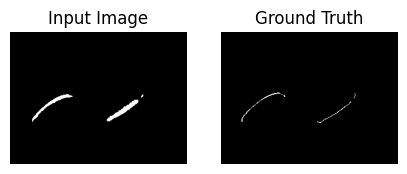

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


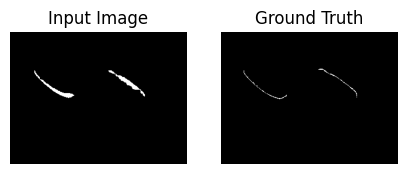

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


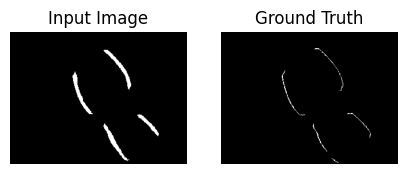

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


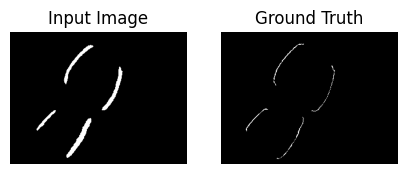

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


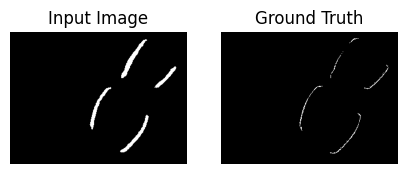

In [ ]:
for test_input, tar in vae_test_dataset_real.take(5):
  plt.figure(figsize=(5,5))
  print('Input_shape', test_input.shape)
  print('Gt shape',tar.shape)
  display_list = [test_input[0], tar[0]]

  title = ['Input Image', 'Ground Truth']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i], cmap='gray')
    plt.axis('off')
  plt.show()

### Save also a processed test dataset of real images.
First you need to load the generator weights trained for the real images. Then create the real datasets to process.

In [ ]:
# REAL
checkpoint.restore(tf.train.latest_checkpoint('drive/MyDrive/Colab_Notebooks/v8/checkpoints_gan_20k/phase2-real_500real_ds-4000epochs_steps500/')) # load cGAN trained for real imgs
train_img_dataset_real = tf.data.Dataset.list_files('real_train_img/*.png', shuffle=False)
train_burrs_dataset_real = tf.data.Dataset.list_files('real_train_burrs/*.png', shuffle=False)
train_dataset_real = tf.data.Dataset.zip((train_img_dataset_real, train_burrs_dataset))

train_dataset_real = train_dataset_real.map(load_image,
                                  num_parallel_calls=tf.data.AUTOTUNE)

train_dataset_real = train_dataset_real.batch(BATCH_SIZE)
vae_train_dataset_real = train_dataset_real.map(process_images)




test_img_dataset_real = tf.data.Dataset.list_files('real_test_img/*.png', shuffle=False)
test_burrs_dataset_real = tf.data.Dataset.list_files('real_test_burrs/*.png', shuffle=False)
test_dataset_real = tf.data.Dataset.zip((test_img_dataset_real, test_burrs_dataset_real))

test_dataset_real = test_dataset_real.map(load_image,
                                num_parallel_calls=tf.data.AUTOTUNE)

test_dataset_real = test_dataset_real.batch(BATCH_SIZE)
vae_test_dataset_real = test_dataset_real.map(process_images)

In [ ]:
# Save real test dataset for vae
save_dataset_to_tfrecord(vae_test_dataset_real, 'drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_test_dataset_real.tfrecord')

In [ ]:
# Save real test dataset for cgan
save_dataset_to_tfrecord(test_dataset_real, 'drive/MyDrive/Colab_Notebooks/datasets/cgan/real/cgan_test_dataset_real.tfrecord')

In [ ]:
# Save real train dataset for cgan
save_dataset_to_tfrecord(train_dataset_real, 'drive/MyDrive/Colab_Notebooks/datasets/cgan/real/cgan_train_dataset_real.tfrecord')

In [ ]:
# Save real train dataset for vae
save_dataset_to_tfrecord(vae_train_dataset_real, 'drive/MyDrive/Colab_Notebooks/v8_extra/datasets_vae/vae_train_dataset_real.tfrecord')

## Create and save a dataset containing aritficial simulation img with just one burr.
To avoid the use of the generator derive these from the already processed burr images to take only the one burr (the biggest) if there are more than one.
This is done to balance the number of images with just one burrs since the are outnumber by images with more burrs.

#### Processing functions for createing a dataset with only one burr images

In [26]:
# Function to obtain the biggest burr and its contours from already processed image dataset
def get_biggest_burr(burr_inp, ext_cont):
  # Find the biggest burr contour using the already defined function to build the general processed dataset
  one_burr = Extract_burr(burr_inp)
  # Find the entire contour of the single burr
  contours_burr, hierarchy = cv2.findContours(one_burr.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  burr_thick = cv2.drawContours(one_burr.copy(), contours_burr, -1, (255, 255, 255), 8)

  # Subtract the bigger burr find to the image with the conotur of the burrs fed as input, to get the non-biggest burrs contours out of the way
  deleted_cont = cv2.subtract(ext_cont.copy(), burr_thick.copy()) # get the contours of smaller burrs to delete
  one_cont = cv2.subtract(ext_cont.copy(), deleted_cont.copy()) # get the remainer contuor of the biggest burr

  return one_burr, one_cont

def process_image_one_burr(burr_inp, ext_cont):
  burr_inp = np.array(tf.keras.utils.array_to_img(burr_inp[0]), dtype=np.uint8)
  ext_cont = np.array(tf.keras.utils.array_to_img( ext_cont[0]), dtype=np.uint8)
  burr_img, cont_img = get_biggest_burr(burr_inp, ext_cont) # one extrated burr, one extracted external contour
  burr_img = burr_img.reshape(IMG_HEIGHT_VAE, IMG_WIDTH_VAE,1)

  cont_img = cont_img.reshape(IMG_HEIGHT_VAE, IMG_WIDTH_VAE,1)

  burr_tensor = tf.convert_to_tensor(burr_img)
  contour_tensor = tf.convert_to_tensor(cont_img)
  return burr_tensor, contour_tensor


def process_images_one_burr(burr_inp_img, cont_gt_img):
    burr_img, contour_img = tf.py_function(process_image_one_burr, [burr_inp_img, cont_gt_img], [tf.uint8, tf.uint8])
    burr_img = tf.cast(burr_img, tf.float32)/255.0
    contour_img = tf.cast(contour_img, tf.float32)/255.0
    burr_img = tf.reshape(burr_img, (1, IMG_HEIGHT_VAE, IMG_WIDTH_VAE, 1))
    contour_img = tf.reshape(contour_img, (1, IMG_HEIGHT_VAE, IMG_WIDTH_VAE, 1))
    return burr_img, contour_img

# to delete images that have no burrs (we only want one burr images)
def is_all_black(image):
    return tf.reduce_all(tf.equal(image, 0))

def should_delete(data_pair):
    burr, cont = data_pair
    return tf.logical_or(is_all_black(burr), is_all_black(cont))

def filter_dataset(dataset):
    return dataset.filter(lambda x, y: not should_delete((x, y)))

# Check dataset info
def check_dataset_info(dataset, name_dataset, return_length=False):
  dataset_length = dataset.reduce(0, lambda x, _: x + 1) # to avoid long time due to iteration
  dataset_length = dataset_length.numpy()
  # Get image resolution
  for input, tar in dataset.take(1):
    image_h = input[0].shape[0]
    image_w = input[0].shape[1]
    image_resol = (image_h, image_w)
  # Get the element spec of the dataset
  element_spec = dataset.element_spec
  # Extract the shape information from the element spec
  batch_size = element_spec[0].shape[0]
  print(f'\033[1mDataset\033[0m:\033[4m{name_dataset}\033[0m | Size: {dataset_length}, Image resol.:{image_resol}, Batch_size: {batch_size}')
  print('____________________________________________________________________________________________________________')
  if return_length:
    return dataset_length

#### Loading the already saved processed datasets

In [15]:
#LOAD PROCESSED DATASETS
# Simulation images datasets
vae_train_dataset_sim = load_dataset_from_tfrecord('drive/MyDrive/Colab_Notebooks/datasets/vae/sim/vae_train_dataset_sim.tfrecord') # 20000 (processed binary burr images, ground-truth extracted burr contour binary images), batch_size=1
vae_val_dataset_sim = load_dataset_from_tfrecord('drive/MyDrive/Colab_Notebooks/datasets/vae/sim/vae_val_dataset_sim.tfrecord') # 500 (processed binary burr images, ground-truth extracted burr contour binary images), batch_size=1
vae_test_dataset_sim = load_dataset_from_tfrecord('drive/MyDrive/Colab_Notebooks/datasets/vae/sim/vae_test_dataset_sim.tfrecord') # 40 (processed binary burr images, ground-truth extracted burr contour binary images), batch_size=1

### Save the one burr processed datasets

In [38]:
ds_len = 5000 # define train dataset length (consider a bigger number that you want cause the majority of black images will be deleted)
ds_len_final = 4500 # the actual final length for your train ds of one burrs
#take the specified number of images form the saved processed datasets
vae_train_dataset_small = vae_train_dataset_sim.take(ds_len)
vae_val_dataset_small = vae_val_dataset_sim
vae_test_dataset_small = vae_test_dataset_sim

#APPLY PROCESSING
vae_train_dataset_one_burr = filter_dataset(vae_train_dataset_small.map(process_images_one_burr)).take(ds_len_final)
vae_val_dataset_one_burr = filter_dataset(vae_val_dataset_small.map(process_images_one_burr))
vae_test_dataset_one_burr = filter_dataset(vae_test_dataset_small.map(process_images_one_burr))

In [39]:
save_dataset_to_tfrecord(vae_test_dataset_one_burr, 'drive/MyDrive/Colab_Notebooks/datasets/vae/sim/vae_test_dataset_one_burr.tfrecord')
save_dataset_to_tfrecord(vae_val_dataset_one_burr, 'drive/MyDrive/Colab_Notebooks/datasets/vae/sim/vae_val_dataset_one_burr.tfrecord')
save_dataset_to_tfrecord(vae_train_dataset_one_burr, 'drive/MyDrive/Colab_Notebooks/datasets/vae/sim/vae_train_dataset_one_burr.tfrecord')

Saved 1 images
Saved 2 images
Saved 3 images
Saved 4 images
Saved 5 images
Saved 6 images
Saved 7 images
Saved 8 images
Saved 9 images
Saved 10 images
Saved 11 images
Saved 12 images
Saved 13 images
Saved 14 images
Saved 15 images
Saved 16 images
Saved 17 images
Saved 18 images
Saved 19 images
Saved 20 images
Saved 21 images
Saved 22 images
Saved 23 images
Saved 24 images
Saved 25 images
Saved 26 images
Saved 27 images
Saved 28 images
Saved 29 images
Saved 30 images
Saved 31 images
Saved 32 images
Saved 33 images
Saved 34 images
Saved 35 images
Saving complete!
Saved 1 images
Saved 2 images
Saved 3 images
Saved 4 images
Saved 5 images
Saved 6 images
Saved 7 images
Saved 8 images
Saved 9 images
Saved 10 images
Saved 11 images
Saved 12 images
Saved 13 images
Saved 14 images
Saved 15 images
Saved 16 images
Saved 17 images
Saved 18 images
Saved 19 images
Saved 20 images
Saved 21 images
Saved 22 images
Saved 23 images
Saved 24 images
Saved 25 images
Saved 26 images
Saved 27 images
Saved 28 

In [ ]:
vae_test_dataset_one_burr = load_dataset_from_tfrecord('drive/MyDrive/Colab_Notebooks/datasets/vae/sim/vae_test_dataset_one_burr.tfrecord') # 40 (processed binary burr images, ground-truth extracted burr contour binary images), batch_size=1

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


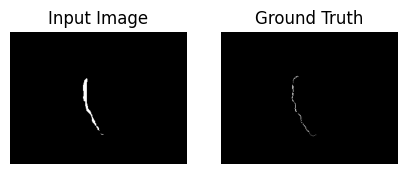

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


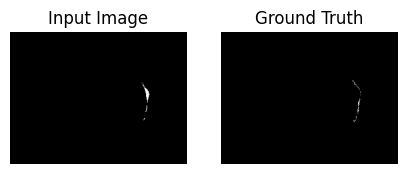

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


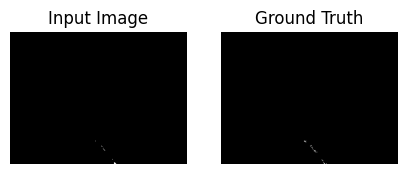

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


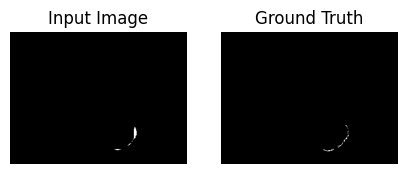

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


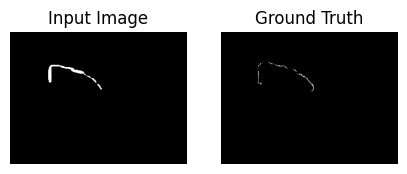

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


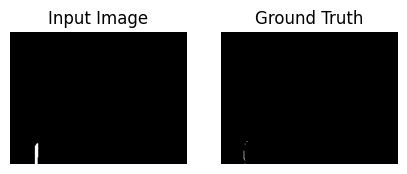

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


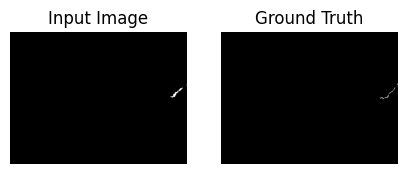

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


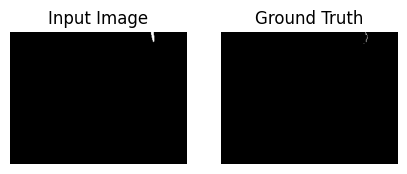

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


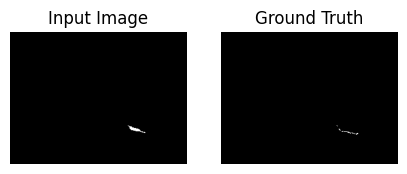

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


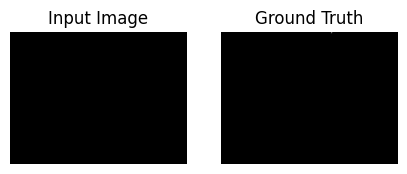

In [35]:
for test_input, tar in vae_train_dataset_one_burr.take(10):
  plt.figure(figsize=(5,5))
  print('Input_shape', test_input.shape)
  print('Gt shape',tar.shape)
  display_list = [test_input[0], tar[0]]

  title = ['Input Image', 'Ground Truth']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i], cmap='gray')
    plt.axis('off')
  plt.show()

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


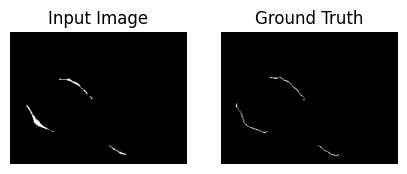

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


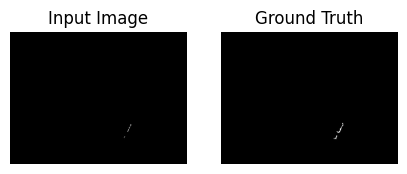

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


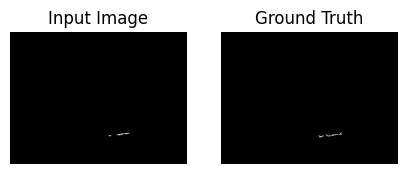

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


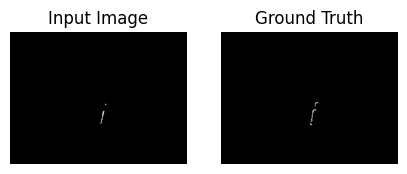

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


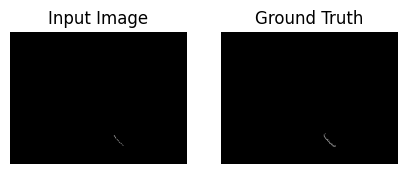

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


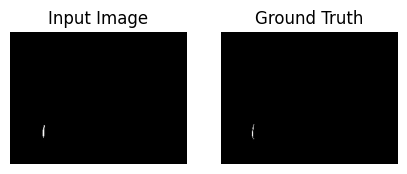

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


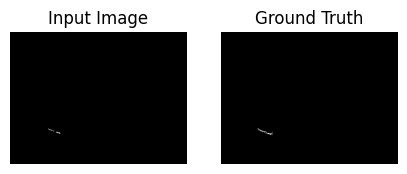

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


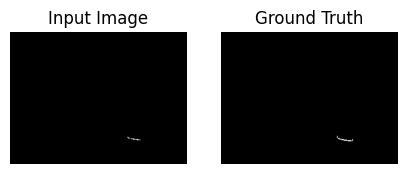

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


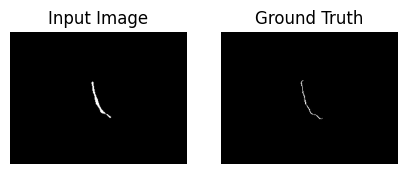

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


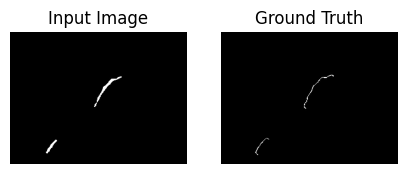

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


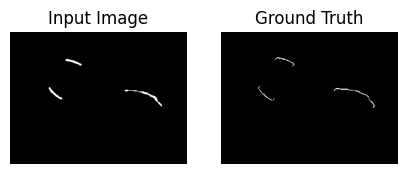

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


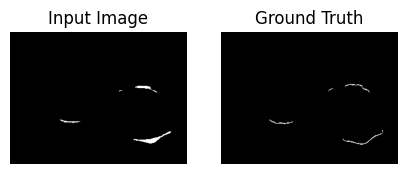

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


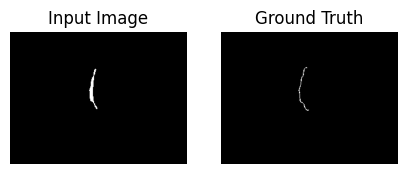

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


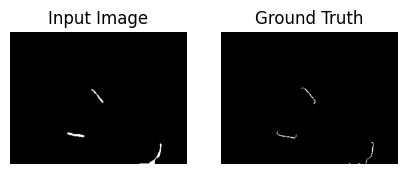

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


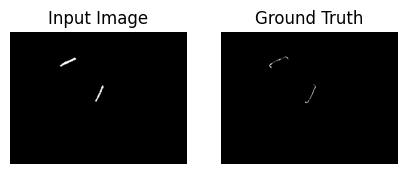

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


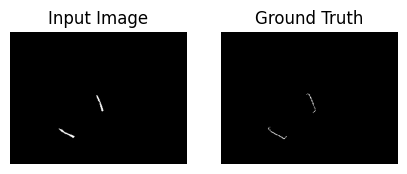

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


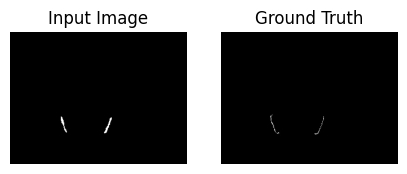

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


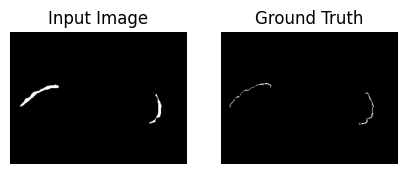

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


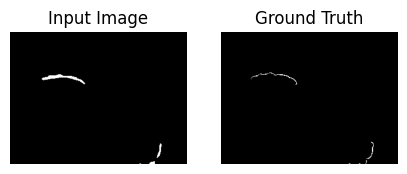

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


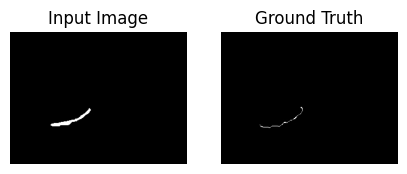

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


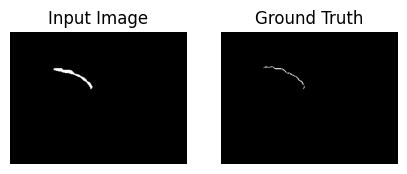

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


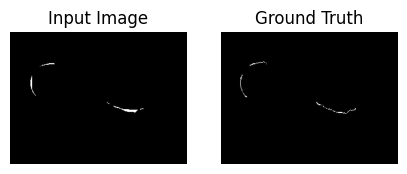

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


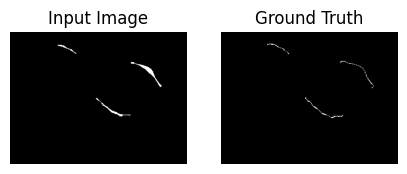

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


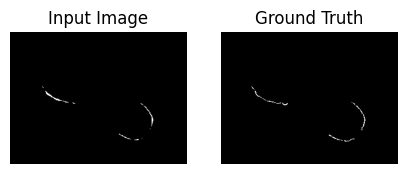

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


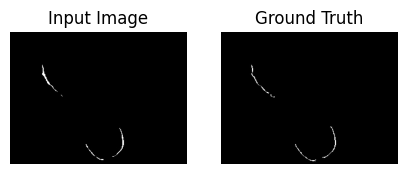

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


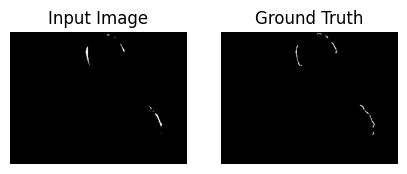

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


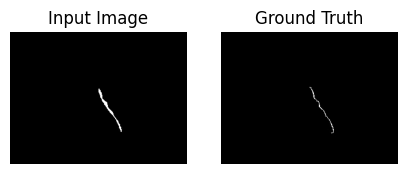

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


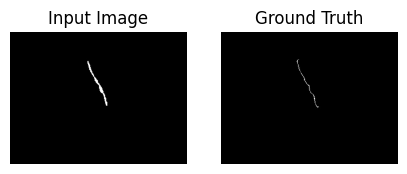

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


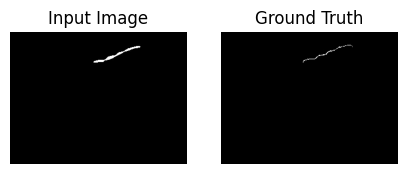

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


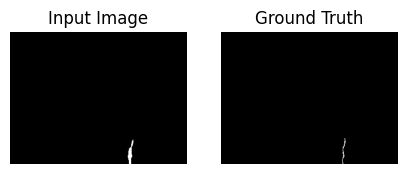

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


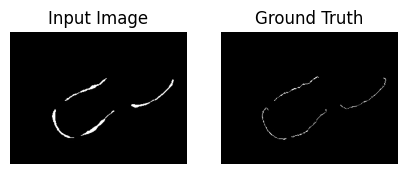

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


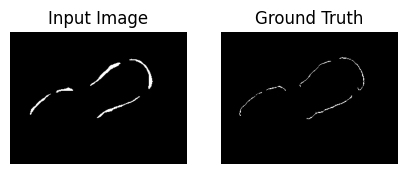

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


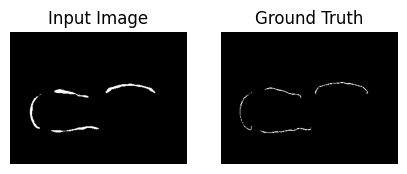

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


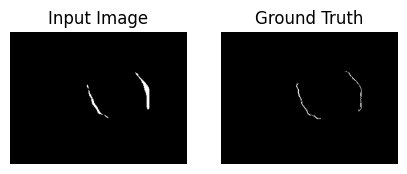

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


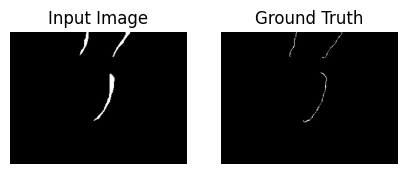

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


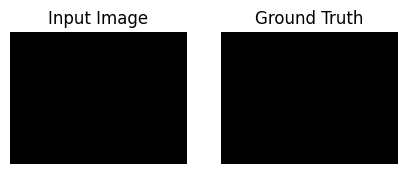

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


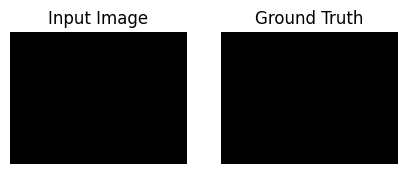

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


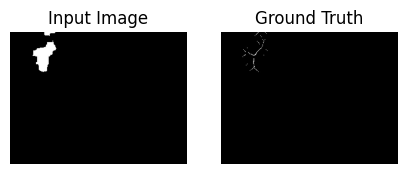

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


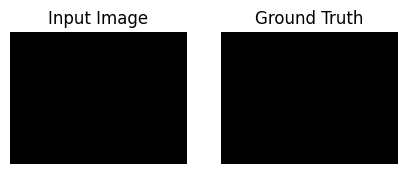

Input_shape (1, 240, 320, 1)
Gt shape (1, 240, 320, 1)


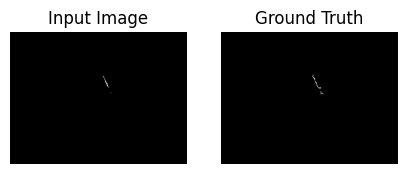

In [23]:
for test_input, tar in vae_test_dataset_small:
  plt.figure(figsize=(5,5))
  print('Input_shape', test_input.shape)
  print('Gt shape',tar.shape)
  display_list = [test_input[0], tar[0]]

  title = ['Input Image', 'Ground Truth']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i], cmap='gray')
    plt.axis('off')
  plt.show()